# Case study: Spis powszechny USA, ciąg dalszy

## Wczytanie danych i inżynieria cech

In [1]:
import pandas as pd
import numpy as np

In [2]:
colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
            'marital_status', 'occupation', 'relationship', 'race', 
            'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 
            'native_country', 'wage_class']

In [3]:
data = pd.read_csv("Dane/adult/adult.data", skipinitialspace=True, names=colnames)
data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
data = data.drop(["fnlwgt"], axis=1)

In [5]:
data["wage_class"] = 1 - (data["wage_class"] == data["wage_class"].iloc[0])

In [6]:
data = data.drop(["education"], axis=1)

In [7]:
data["marital_status"] = data.marital_status.replace(
    {"Married-AF-spouse": "Married-civ-spouse"}
)  # w praktyce ta nazwa zmienia znaczenie, wiec można by ją zmienic

In [8]:
data["sex"] = data["sex"].replace({"Male": 0, "Female": 1})

In [9]:
# trick na "przyciągniecie" dużych wartości do zera z zachowaniem uporządkowania z myślą o modelach liniowych
# w praktyce można porobić eksperymenty na dobór konkretnego wzoru

data["capital_gain"] = np.log(1+data.capital_gain/1000)
data["capital_loss"] = np.log(1+data.capital_loss/1000)

In [10]:
data["is_native_us"] = (data["native_country"] == "United-States").astype(int)
data = data.drop(["native_country"], axis=1)

In [11]:
y = data.wage_class
X = data.drop(["wage_class"], axis=1)

In [12]:
X = pd.get_dummies(X)
X.head(2)

,age,education_num,sex,capital_gain,capital_loss,hours_per_week,is_native_us,workclass_?,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,0,1.154993,0.0,40,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,50,13,0,0.000000,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X[
    ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
] = scaler.fit_transform(
    X[["age", "education_num", "capital_gain", "capital_loss","hours_per_week"]]
)
# formalnie powinnismy to robic po podziale na train-test

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [16]:
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8550665301944729

## Komitety algorytmów (ensembling)

### Las losowy
(drzewo korzysta ze wszystkich zmiennych, na każdym etapie wybierając podzbiór cech)

In [17]:
from sklearn.ensemble import RandomForestClassifier
# RandomForestClassifier?  # domyślnie 100 drzew decyzyjnych

In [18]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8536335721596725

### Bagging
(na samym początku wybieramy podzbiór cech, na których trenujemy drzewo)

In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier  # jeden z możliwych estymatorów (domyślny)
# ?BaggingClassifier

In [23]:
model = BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=5),
                          n_estimators=100, max_samples=0.5, max_features=0.5)  # domyślnie: n_estimators=10

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8671443193449335

### Boosting
(sekwencyjna budowa algorytmów - iteracyjna optymalizacja)

In [24]:
from sklearn.ensemble import AdaBoostClassifier  # jeden z najpopularniejszych algorytmów
# ?AdaBoostClassifier

In [34]:
model = AdaBoostClassifier(n_estimators=200)  # domyślnie: drzewo decyzyjne w standardowej konfiguracji

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8681678607983623

In [35]:
from sklearn.svm import LinearSVC

In [46]:
# porównanie 'emsemble learning' z tradycyjnym modelem (skuteczność podobna dla małych danych)

model = LinearSVC()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

/home/mdabrowski-phd/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8546571136131014

## XGBoost

**XGBoost** jest to komitet drzew regresyjnych, który stosuje się zarówno do problemu regresji jak i klasyfikacji. Jest to jeden z przykładów klasy algorytmów *gradient boosting'u* - polega na minimalizacji odpowiedniej funkcji kosztu. Dokładny opis: http://xgboost.readthedocs.io/en/latest/tutorials/model.html 

Wartość zwracana przez model (dla $i$-tej obserwacji):

$$\hat{y}_i = \sum\limits_{k=1}^K f_k(x_i),$$
gdzie $f_k(\cdot)$ - wartość (liczba rzeczywista) zwracana przez $k$-te drzewo.

<br>

**Predykcja zależy od problemu:**

1) Regresja: $pred_i = \hat{y}_i $
    
2) Klasyfikacja binarna: $pred_i = p(x_i) = sigmoid(\hat{y}_i) = \frac{1}{1+\exp{(-\hat{y}_i)}}$
  
3) Klasyfikacja wieloklasowa: $pred_i^c =softmax(\hat{y}_i)^c = \frac{\exp{(\hat{y}_i^c)}}{\sum\limits_c\exp{(\hat{y}_i^c)}}$

<br>

### Uczenie modelu

**Budowanie komitetu** polega na konstruowaniu kolejnych drzew w taki sposób, aby zminimalizować fukcję celu:

$$Obj(\Theta) = L(\Theta) + \Omega(\Theta),$$

gdzie

$\Theta$ - model (zestaw konkretnych drzew)

$L(\Theta)$ - funkcja straty (miara dopasowania modelu)

$\Omega(\Theta)$ - regularyzacja (miara złożoności modelu)

<br>

**Fukcja straty** zależy od problemu:

1) Regresja - funkcja straty *kwadratowa*: $\sum\limits_i (y_i - \hat{y}_i)^2$

2) Klasyfikacja binarna - funkcja straty *log-loss* (_binomial cross-entropy_): $ - \frac{1}{n}\sum\limits_{i=1}^n \big( y_i\log(p(x_i)) + (1-y_i)\log(1-p(x_i))   \big) $

3) Klasyfikacja wieloklasowa - funkcja straty *log-loss* (_multinomial cross-entropy_): $ = -\frac{1}{n}\sum_{i=1}^n\sum\limits_c y_{ij} \log(p(x_i)_j) $

<br>

Drzewa uczone są iteracyjnie:

\begin{split}\hat{y}_i^{(0)} &= 0\\
\hat{y}_i^{(1)} &= f_1(x_i) = \hat{y}_i^{(0)} + f_1(x_i)\\
\hat{y}_i^{(2)} &= f_1(x_i) + f_2(x_i)= \hat{y}_i^{(1)} + f_2(x_i)\\
&\dots\\
\hat{y}_i^{(t)} &= \sum_{k=1}^t f_k(x_i)= \hat{y}_i^{(t-1)} + f_t(x_i)
\end{split}

W danym kroku znajdujemy drzewo, które najlepiej poprawia naszą funkcję celu.

<br>

### **Regularyzacja**

\begin{split}\Omega(\Theta) = \sum_{i=1}^t\Omega(f_i),  \\
\Omega(f) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2 \ \Big( +\alpha\sum_{j=1}^T |w_j| \Big)  ,
\end{split}

gdzie $T$ - liczba liści w drzewie $f$, $w_j$ wartość zwracana przez drzewo dla obseracji w $j$-tym liściu. Uwaga: wartości $w_{(\cdot)}$ są wyliczane na podstawie funkcji celu - w przybliżeniu znajdowane są takie, które dają najlepszy wynik.

W praktyce dodaje się kolejną regularyzację (gdzie $\eta$ - _learning rate_):

$$\hat{y}_i^{(k)} = \hat{y}_i^{(k-1)} + \eta \cdot f_k(x_i),$$

<br>

**Przykład modelu złożonego z dwóch drzew:**

<img src="Grafika/xgboost.png" width = 500>

https://xgboost.readthedocs.io/en/latest

In [37]:
# !pip install xgboost  # niezależna biblioteka dostępna w różnyh językah programowania

from xgboost.sklearn import XGBClassifier  # możliwość integracji jako jeden z elementów 'pipeline'
# ?XGBClassifier

In [38]:
model = XGBClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)  # wynik najlepszy z testowanych dotychczas modeli (parametry domyślne!)

0.8734902763561925

### Randomizowane poszukiwanie parametrów (Randomized search)

Stosujemy w sytuacji optymalizowania bardzo dużej liczby hiperparametrów.

<img src="Grafika/randomized_search.png" width = 500>

**Optymalizacja bayesowska** - podobna, ale jeszcze sprytniejsza niż randomized search: https://optuna.org/

In [74]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

model = XGBClassifier()

distributions = { 
    "n_estimators": [50, 75],
    "learning_rate": uniform(loc=0, scale=0.7),
    "max_depth": range(4, 9),  # [4, .., 8]
    "gamma": uniform(loc=0, scale=1),
    "lambda": uniform(loc=0, scale=1),
    "subsample": [0.75, 1.0],
    "colsample_bynode": [0.75, 1.0]
    }

optimizer = RandomizedSearchCV(model,
                               distributions,
                               n_iter=5,  # w praktyce: n_iter=100
                               cv=10,  # można zredukować do cv=5, żeby było szybciej
                               random_state=0)

optimizer = optimizer.fit(X_train, y_train)

print(optimizer.best_params_)
print(optimizer.best_score_)

{'colsample_bynode': 0.75, 'gamma': 0.8009107519796442, 'lambda': 0.5204774795512048, 'learning_rate': 0.4752156710832722, 'max_depth': 4, 'n_estimators': 75, 'subsample': 1.0}
0.8731028079700683


In [79]:
results = pd.DataFrame(optimizer.cv_results_["params"])

results["score"] = optimizer.cv_results_["mean_test_score"]
results.sort_values("score", ascending=False).reset_index(drop=True)

,colsample_bynode,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,score
0,0.75,0.800911,0.520477,0.475216,4,75,1.00,0.873103
1,0.75,0.592845,0.844266,0.600562,5,75,1.00,0.870501
2,1.00,0.528895,0.568045,0.647918,4,75,0.75,0.869128
3,0.75,0.437587,0.891773,0.674564,6,75,0.75,0.863817
4,1.00,0.368242,0.957155,0.098246,4,50,1.00,0.861360


In [75]:
# inny sposób: model_best = XGBClassifier(**optimizer.best_params_)

y_pred = optimizer.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred)

0.8749232343909928

In [82]:
ooptimizer.best_estimator_.feature_importances_

array([0.01222139, 0.04731385, 0.01276315, 0.04033818, 0.01899349,
       0.01100805, 0.00365046, 0.00212255, 0.01223534, 0.00596178,
       0.        , 0.00312046, 0.00711746, 0.00715456, 0.00435957,
       0.        , 0.00300774, 0.45849758, 0.00347901, 0.0914612 ,
       0.0034624 , 0.00697685, 0.00639196, 0.00487152, 0.        ,
       0.00337699, 0.04135457, 0.01706287, 0.0077031 , 0.00532079,
       0.02096909, 0.00263538, 0.02794941, 0.00467133, 0.00658858,
       0.01740884, 0.00263349, 0.00258967, 0.00522495, 0.00543294,
       0.03212523, 0.00286748, 0.00954289, 0.003502  , 0.00313448,
       0.00410236, 0.001613  , 0.00568198], dtype=float32)

In [84]:
optimizer.best_estimator_.predict_proba(X_test[:3])[:, 1]

array([0.3164064 , 0.09319952, 0.01692411], dtype=float32)

In [89]:
params_importance = pd.DataFrame(
            {"feature": optimizer.best_estimator_.feature_importances_,
             "feature_names": optimizer.best_estimator_.feature_names_in_}
    ).sort_values("feature", ascending=False).reset_index(drop=True)

params_importance.head()

,feature,feature_names
0,0.458498,marital_status_Married-civ-spouse
1,0.091461,marital_status_Never-married
2,0.047314,education_num
3,0.041355,occupation_Exec-managerial
4,0.040338,capital_gain


## Problem nierównomierności klas (_imbalanced data_)


**Podejścia:**

- manipulacja progiem klasyfikacji 
- wykorzystanie ważonej funkcji celu podczas uczenia modeli
- repróbkowania:
    - over-sampling
    - under-sampling
    - inne bardziej złożone schematy
- data augmentation - sztuczne tworzenie nowych obserwacji (np. SMOTE dla danych tabelarycznych; przede wszystkim przy pracy z obrazami)
- podejścia inne niż klasyfikacja (detekcja obserwacji nietypowych, własne heurystyki)

<img src="Grafika/resampling.png" width = 500>

In [91]:
# klasy są "lekko" niezbalansowane
y_train.mean()

0.24042491689550513

In [90]:
model = RandomForestClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8501535312180143

In [93]:
weights = [{0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}]  # {klasa: proporcja}

for class_weights in weights:
    
    model = RandomForestClassifier(class_weight=class_weights)  # parametr do ważenia funkcji błędu

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(class_weights, accuracy_score(y_test, y_pred))

{0: 1, 1: 2} 0.8464687819856704
{0: 1, 1: 3} 0.8452405322415558
{0: 1, 1: 4} 0.8470829068577277


### Biblioteka `imbalanced-learn`

Sklearn nie zawiera funkcjonalności odnoszących się do problemu niezbalansowanych klas, ale istnieje do tego inny pakiet, w którym pracuje się tak samo jak w sklearnie:**
http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html

**SMOTE:**

<img src="Grafika/smote.png" width = 500>

**Do poczytania:** https://svds.com/learning-imbalanced-classes/

In [108]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # nie możemy użyć Pipeline() ze 'sklearn'
# ?SMOTE

In [112]:
augmenter = SMOTE(sampling_strategy=0.5)

X_aug, y_aug = augmenter.fit_resample(X_train, y_train)
X_aug.shape, X_train.shape

((31533, 48), (27676, 48))

In [115]:
pipeline = Pipeline([
    ("augmenter", augmenter),
    ("model", XGBClassifier())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

accuracy_score(y_test, y_pred)

0.8696008188331628

In [119]:
# optymalizacja modelu na siatce hiperparametrów

pipeline = Pipeline([
    ("augmenter", SMOTE()),  # powiększamy zbiór danych, więc wydłużamy obliczenia!
    ("model", XGBClassifier())
])

distributions = {
    "augmenter__sampling_strategy":[0.5, 1],
    "model__n_estimators": [50, 75],
    "model__learning_rate": uniform(loc=0, scale=0.7)
}

optimizer = RandomizedSearchCV(pipeline,
                               distributions,
                               n_iter=5,
                               cv=5,
                               random_state=0)

optimizer = optimizer.fit(X_train, y_train)

print(optimizer.best_params_)
print(optimizer.best_score_)

{'augmenter__sampling_strategy': 0.5, 'model__learning_rate': 0.4149912327575128, 'model__n_estimators': 50}
0.8674301084533003


In [120]:
y_pred = optimizer.predict(X_test)
accuracy_score(y_test, y_pred)

0.8687819856704196

## Krzywa ROC i wskaźnik AUC

Mamy wektor prawdziwych klas $y = [0, 1, 1, ..., 0, 0]$ oraz wektor prawdopodobieństw zwrócony przez klasyfikator $p = [0.35, 0.55, 0.91, ..., 0.1, 0.44]$. Klasyfikujemy obserwacje według reguły $p(x) > t$ dla pewnego progu $t$.

Zdefiniujmy:
 - _false positive rate_ FPR - procent obserwacji klasy $0$ zaklasyfikowanych jako $1$,
 - _true positive rate_ TPR - procent obserwacji klasy $1$ zaklasyfikowanych jako $1$.

Obliczamy TPR($t$) oraz FPR($t$) dla każdego $t\in p$. Krywa ROC to wykres liniowy powstały z punktów (FPR($t$), TPR($t$)) (dla $t$ uporządkowanych malejąco).

**Wskaźnik AUC** to wielkość pola pod **krzywą ROC**. Im wyżej leży krzywa, tym większe AUC i tym lepszy model:
- AUC bliskie 0.5 - model o praktycznie zerowej mocy predykcjyjnej
- AUC bliskie 1 - model bardzo dobry. 

**Uwaga:** W praktyce korzysta się czasem wielkości wskaźnika Giniego: $gini = 2 * AUC - 1$, czyli jest to proste przekształcenie AUC. Chodzi o to, że dla AUC=0.5 gini = 0, a dla AUC = 1, gini = 1. Czyli zamiast operować na wielkości AUC z przedziału (0.5, 1), przenosimy się na skalę (0,1). 

<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png" width="400">

Źródło: http://scikit-learn.org/stable/_images/sphx_glr_plot_roc_001.png

### Wskaźnik AUC
(całka pod wykresem krzywej **ROC**, łączącej **TPR** oraz **FPR** dla kolejnych progów klasyfikacji)

In [94]:
from sklearn.metrics import roc_auc_score

In [95]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

y_probs = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_probs)

0.8971761415697276

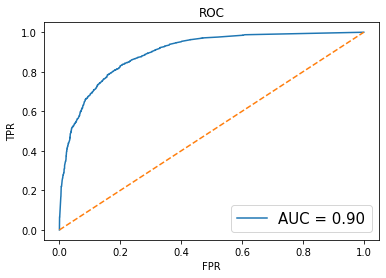

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y = y_test
scores = y_probs
fpr, tpr, thresholds = roc_curve(y, scores)

# print(thresholds)
# print(fpr)
# print(tpr)

plt.plot(fpr,tpr, label = "AUC = %.2f" % roc_auc_score(y, scores))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc="lower right", prop={'size':15})
plt.show()

### Optymalizacja konkretnej metryki
(domyślnie optymalizowana jest dokładność - *accuracy*)

In [101]:
model = XGBClassifier()

distributions = { 
    "n_estimators": [50, 75],
    "learning_rate": uniform(loc=0, scale=0.7),
    "max_depth": range(4, 9),  # [4, .., 8]
    "gamma": uniform(loc=0, scale=1),
    "lambda": uniform(loc=0, scale=1),
    "subsample": [0.75, 1.0],
    "colsample_bynode": [0.75, 1.0]
    }

optimizer = RandomizedSearchCV(model,
                               distributions,
                               scoring="roc_auc",  # metryka, którą optymalizujemy! (domyślnie: "accuracy")
                               n_iter=5,
                               cv=10,
                               random_state=0)

optimizer = optimizer.fit(X_train, y_train)

In [102]:
print(optimizer.best_params_)
print(optimizer.best_score_)

{'colsample_bynode': 0.75, 'gamma': 0.8009107519796442, 'lambda': 0.5204774795512048, 'learning_rate': 0.4752156710832722, 'max_depth': 4, 'n_estimators': 75, 'subsample': 1.0}
0.9288824721536196


In [103]:
results = pd.DataFrame(optimizer.cv_results_["params"])

results["score"] = optimizer.cv_results_["mean_test_score"]
results.sort_values("score", ascending=False).reset_index(drop=True)

,colsample_bynode,gamma,lambda,learning_rate,max_depth,n_estimators,subsample,score
0,0.75,0.800911,0.520477,0.475216,4,75,1.00,0.928882
1,0.75,0.592845,0.844266,0.600562,5,75,1.00,0.925585
2,1.00,0.528895,0.568045,0.647918,4,75,0.75,0.923658
3,1.00,0.368242,0.957155,0.098246,4,50,1.00,0.917803
4,0.75,0.437587,0.891773,0.674564,6,75,0.75,0.916886


In [106]:
y_probs = optimizer.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_probs)

0.9311733203083887

## Walidacja krzyżowa (cross-validation)

In [122]:
from sklearn.model_selection import KFold, StratifiedKFold
# ?KFold
# ?StratifiedKFold  # uwzględnia niezbalansowanie klas

In [123]:
# kfold = KFold(10)
kfold = StratifiedKFold(10, shuffle=True, random_state=123)  # losowa kolejność danych przed podziałem

pipeline = Pipeline([
    ("augmenter", SMOTE()),
    ("model", XGBClassifier())
])

distributions = {
    "augmenter__sampling_strategy":[0.5, 1],
    "model__n_estimators": [50, 75],
    "model__learning_rate": uniform(loc=0, scale=0.7)
}

optimizer = RandomizedSearchCV(pipeline,
                               distributions,
                               scoring="roc_auc",
                               n_iter=5,
                               cv=kfold,  # tu możemy zewnętrznie zdefiniować podział danych
                               random_state=0)

optimizer = optimizer.fit(X_train, y_train)

In [124]:
y_probs = optimizer.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_probs)

0.9289405051934991

### Podział na część treningową i walidacyjną
(*cross-walidacja* na dużym zbiorze danych jest kosztowna obliczeniowo)

In [126]:
# PRZYKŁAD: wygenerowanie podziału na część treningową i walidacyjną

from sklearn.model_selection import StratifiedShuffleSplit

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)

for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

StratifiedShuffleSplit(n_splits=1, random_state=0, test_size=0.2,
            train_size=None)
Fold 0:
  Train: index=[2 5 1 3]
  Test:  index=[0 4]


In [127]:
train_valid_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

pipeline = Pipeline([
    ("augmenter", SMOTE()),
    ("model", XGBClassifier())
])

distributions = {
    "augmenter__sampling_strategy":[0.5, 1],
    "model__n_estimators": [50, 75],
    "model__learning_rate": uniform(loc=0, scale=0.7)
}

optimizer = RandomizedSearchCV(pipeline,
                               distributions,
                               scoring="roc_auc",
                               n_iter=5,
                               cv=train_valid_split,
                               random_state=0)

optimizer = optimizer.fit(X_train, y_train)

In [128]:
y_probs = optimizer.best_estimator_.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_probs)

0.9279765058915245

# Jak obsługiwać braki danych?

## Propozycja w przypadku zmiennej numerycznej:

1. Gdy dla danej zmiennej braków jest bardzo mało (np. 2% zbioru), wyrzucić obserwacje zawieracjące te braki.

2. Gdy dla danej zmiennej braków jest bardzo dużo (ponad 60%), usunąć z danych tę zmienną

3. W pozostałych przypadkach uzupełnić braki średnią.


**To NIE jest dobre podejście!**

## Podejście rzetelne:

**1) Spróbować wyjaśnić pochodzenie braków**
  - może wynikają z błędu w jakimś systemie -> trzeba naprawić system
  - może ktoś nie wiedzał jakie wartości wprowadzić -> trzeba stworzyć lepszą (jakąkolwiek) dokumentację/instrukcję
  - itd.
  - jak to wygląda w praktyce? ...
  - wyjaśnienie jest super, ale często nierealizowalne (co nie znaczy, że nie warto próbować), dlatego trzeba sobie radzić
  
**2) Spróbować wyjaśnić znaczenie braku**
  - brak w kolumnie "liczba dzieci" -> może oznaczać wartość 0
  - brak w kolumnie "wykształcenie" -> może oznaczać, że osoba nie ma nawet podstawowego
  - brak może wynikać z wartości innej zmiennej -> czy posiadasz dzieci - nie, liczba dzieci - brak
  - wówczas braki możemy uzupełnić. 
  
**3) Jeżeli rozważamy zmienną kategoryczną:**
  - warto rozważyć nadanie brakom klasy "brak" i traktować ją jak normalna wartość,
  - można tez upełnić wartością występującą najczęściej lub wartością losową,
  - jeżeli braki stanowią przytłaczającą większość -> można zamienić zmienną na binarną o wartości 1, gdy wystepuje brak lub 0 wpp.

**4) Jeżeli rozważamy zmienną numeryczną:**
  - można uzupełnić średnią -> gdy zmienna ma rozkład symetryczny,
  - można uzupełnić medianą lub modą -> gdy zmienna ma rozkład skośny,
  - można tez upełnić wartością występującą wartością losową (z rozsądnego rozkładu),
  - jeżeli braki stanowią przytłaczającą większość -> można zamienić zmienną na binarną o wartości 1, gdy wystepuje brak lub 0 wpp.
  - można skategoryzować zmienną - wartości numeryczne pogrupować na przedziały i dodać kategorię "brak"
  - uzupełnić braki i jednocześnie dodać do danych zmienną binarną o wartości 1, gdy wystepuje brak lub 0 w,pp.,
  - jeżeli dane są zależne od czasu, można uzupełnić wartością poprzednią/ średnią z porzednich kilku wartości, wartością, która zachowałaby trend z poprzednich kilku wartości,
  - uzupełnić wartością spoza zakresu i używać algorytmów drzewiastych.
  
**5) Uzupełnić na podstawie prostej zależności względem innych zmiennych.** Np zmienną numeryczną uzupełnimy średnią wartością tej zmiennej wśród innych obserwacji, które w jakiejś zmiennej mają te samą kategorię.
  
**6) Usunąć obserwacje z brakiem jeśli jest ich mało.**

**7) Usunąć zmienną jeśli braków jest dużo.**

**8) Uzupełnić używając modelu predykcyjnego z wykorzystaniem pozostałych zmiennych** (jeżeli dane zależne od czasu, to można uzupełnić predykcją na podstawie poprzednich wartości tej i inyych zmiennych).